# First we will run experiments on using six landmarks only. We will use the folds that were created. 
# We will edit these parameters to see what works best: 
- learning rate
- augmentations / no augmentations
- model space for LSTM cell 

In [9]:
import random, cv2
import mediapipe as mp
import tensorflow as tf 
tf.config.run_functions_eagerly(True)
from tensorflow.keras.callbacks import ReduceLROnPlateau

def _shift(X):
        
        X = tf.Variable(X, dtype = tf.float32)
        
        X_locations = X[:, :42] # [100, 42]
        Y_locations = X[:, 42:84] # [100, 42]
        Z_locations = X[:, 84:] # [100, 42]
        
        maximum = tf.math.reduce_max(Y_locations)
        minimum = tf.math.reduce_min(Y_locations)
        if maximum == 2: 
            # get the second highest 
            values, _ = tf.nn.top_k(tf.reshape(Y_locations, -1), tf.shape(tf.reshape(X_locations, -1))[0])
            try: 
                values, _ = tf.unique(values)
                maximum = values[1]
            except Exception as e: 
                maximum = 0 
            
        can_move_up = 1 - maximum # the amount it can move up 
        can_move_down = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            #print("up")
            # move up in this case 
            move_up = tf.random.uniform((1,), 0, can_move_up)
            X[:, 42:84].assign(X[:,42:84] + move_up)

        else: 
            move_down = tf.random.uniform((1,), 0, can_move_down)
            X[:, 42:84].assign(X[:,42:84]-move_down)

        maximum = tf.math.reduce_max(X_locations)
        minimum = tf.math.reduce_min(X_locations)
        
        if maximum == 2: 
            values, _ = tf.nn.top_k(tf.reshape(X_locations, -1), tf.shape(tf.reshape(X_locations, -1))[0])
            # create a set. 
            try: 
                values, _ = tf.unique(values)
                maximum = values[1]
            except Exception as e: 
                maximum = 0 
            
        can_move_right = 1 - maximum 
        can_move_left = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            #print("right")
            # move right
            move_right = tf.random.uniform((1,), 0, can_move_right)
            X[:, :42].assign(X[:,:42]+move_right)
        else: 
            # move left 
            move_left = tf.random.uniform((1,), 0, can_move_left)
            X[:, :42].assign(X[:,:42]-move_left)

        
        maximum = tf.math.reduce_max(Z_locations)
        minimum = tf.math.reduce_min(Z_locations)
        if maximum == 2: 
            values, _ = tf.nn.top_k(tf.reshape(Z_locations, -1), tf.shape(tf.reshape(X_locations, -1))[0])
            try: 
                values, _ = tf.unique(values)
                maximum = values[1]
            except Exception as e:  
                maximum = 0 
        
        can_move_far = 1 - maximum 
        can_move_close = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            # move right
            move_far = tf.random.uniform((1,), 0, can_move_far)
            X[:, 84:].assign(X[:,84:]+move_far)
        else: 
            # move left 
            move_close = tf.random.uniform((1,), 0, can_move_close)
            X[:, 84:].assign(X[:,84:]-move_close)

        return X

class Augmenter(tf.keras.layers.Layer): 
    def __init__(self, rotation_range = None): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        self.rotation_range = rotation_range 
    
    def _rotate(self, X):  
        """
        new_x = X * np.cos(theta * np.pi/180) + y * np.sin(theta * np.pi/180)
        new_y = -X * np.sin(theta* np.pi/180) + y * np.cos(theta * np.pi/180)
        """
        X = tf.Variable(X, dtype = tf.float32)

        pi = 3.1415
        rotate_by = tf.random.uniform((1,), -self.rotation_range, self.rotation_range)
        X[:, :12].assign(X[:, :12] * tf.math.cos(rotate_by * pi/180) + X[:, 12:24] * tf.math.sin(rotate_by * pi/180))
        X[:, 12:24].assign(X[:, 12:24] * tf.math.cos(rotate_by * pi/180) - X[:, :12] * tf.math.sin(rotate_by * pi/180))
        return X 

    def call(self, X, training = True):
        if training: 
            X =  tf.map_fn(_shift, X)
            if self.rotation_range: 
                X = tf.map_fn(self._rotate, X)
            return X
        else: 
            return X 

class TTAugmenter(tf.keras.layers.Layer): 
    """apply augmentation during test-time too"""
    def __init__(self, rotation_range = None): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        self.rotation_range = rotation_range 
    
    def _rotate(self, X):  
        """
        new_x = X * np.cos(theta * np.pi/180) + y * np.sin(theta * np.pi/180)
        new_y = -X * np.sin(theta* np.pi/180) + y * np.cos(theta * np.pi/180)
        """
        X = tf.Variable(X, dtype = tf.float32)

        pi = 3.1415
        rotate_by = tf.random.uniform((1,), -self.rotation_range, self.rotation_range)
        
        X[:, :12].assign(X[:, :12] * tf.math.cos(rotate_by * pi/180)  - X[:, 12:24] * tf.math.sin(rotate_by * pi/180))
        X[:, 12:24].assign(X[:, 12:24] * tf.math.cos(rotate_by * pi/180) + X[:, :12] * tf.math.sin(rotate_by * pi/180))
        return X 

    def call(self, X):
        X =  tf.map_fn(_shift, X)
        if self.rotation_range: 
            X = tf.map_fn(self._rotate, X)
        return X 

class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_accuracy') > 0.9):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(0.9*100))   
            self.model.stop_training = True  

#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
import matplotlib.pyplot as plt 
def plot(history, show_pr = False, num = None): 
    
    if num: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision_{num}'], label = "train_precision")
            plt.plot(history.history[f'val_precision_{num}'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall_{num}'], label = "train_recall")
            plt.plot(history.history[f'val_recall_{num}'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    else: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision'], label = "train_precision")
            plt.plot(history.history[f'val_precision'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall'], label = "train_recall")
            plt.plot(history.history[f'val_recall'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    # let's see whether it can detect me not doing anything 

def predict_on_video(model, path): 
    LOCATIONS = []
    cap = cv2.VideoCapture(path)
    while cap.isOpened():
        _, frame = cap.read()
        if not _: break 

        LOCATIONS.append(hand_locations(frame))
    LOCATIONS = pad(np.array([LOCATIONS]),maxlen=90)
    return model.predict(LOCATIONS)

def hand_locations(frame, min_detection_confidence = 0.5, min_tracking_confidence = 0.5): 
    """Only give 6 landmarks"""

    hands = mp.solutions.hands.Hands(min_detection_confidence=min_detection_confidence, min_tracking_confidence=min_tracking_confidence) # MAKE SURE THIS IS ALL GOOD 
    results = hands.process(frame.astype('uint8'))
    X_locations = [0] * 12
    Y_locations = [0] * 12
    Z_locations = [0] * 12

    if results.multi_hand_landmarks:
        x = y = z = 0 
        for hand, hand_landmark in enumerate(results.multi_hand_landmarks):
            for i in range(0, 21):
                if i not in [0, 4, 8, 12, 16, 20]: continue 
                landmark = hand_landmark.landmark[i]
                X_locations[x] = landmark.x
                Y_locations[y] = landmark.y 
                Z_locations[z] = landmark.z
                x += 1; y += 1; z +=1; 
                break # take only the first landmark
            
    hands.close()
    return np.concatenate([X_locations, Y_locations, Z_locations]) 

def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = locations.tolist() 
    empty_row = np.zeros((1, 36))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)

In [10]:
import pickle
import os
import numpy as np 

X = []
y = []

for file in os.listdir('six_point_folds'): 
    with open(f"six_point_folds/{file}", 'rb') as f: 
        X_i, y_i = pickle.load(f)
        X.append(X_i)
        y.append(y_i)

X = np.array(X)
y = np.array(y)

In [30]:
from glob import glob
def cross_validate(model, epochs = 50, callbacks=[]):
    for i in range(X.shape[0]): 
        X_test, y_test = X[i], y[i]
        X_train = np.concatenate([X_j for j, X_j in enumerate(X) if i != j])
        y_train = np.concatenate([y_j for j, y_j in enumerate(y) if i != j])

        M = np.random.permutation(X_train.shape[0])
        X_train, y_train = X_train[M], y_train[M]
        # train 
        history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, callbacks = callbacks)

        # plot accuracy and loss 
        plot(history)

        # evaluate on our own custom videos
        for file in glob("*.mov"):
            print(f"file is {file}, prediction is {predict_on_video(model, file)}")

In [19]:
from copy import deepcopy
from tqdm import tqdm 
for i, model in enumerate([model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_8, model_9, model_10, model_11]): 
    aug_model = deepcopy(model)
    aug_model.layers.insert(0, Augmenter()) # insert augmentation layer 
    assert model.layers != aug_model.layers
    early_stopping_10 = tf.keras.callbacks.EarlyStopping(patience=10)
    early_stopping_5 = tf.keras.callbacks.EarlyStopping(patience=5)

    patience = [5, 10]
    
    for i, test_model in enumerate([model, aug_model]):
        for learning_rate in [0.01, 0.001, 0.0005, 0.0001]: 
            for i, early_stopping in enumerate([early_stopping_5, early_stopping_10]):
                print(f"using patience of {patience[i]}") 
                test_model.compile(loss = 'binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics = ['accuracy'])    
                print(f"using {['no aug', 'aug'][i]} with lr {learning_rate}")
                try: 
                    cross_validate(test_model, callbacks=[early_stopping])
                except Exception as e: 
                    print(f"failed training because of {e}")
    print(f"onto model {i + 1}")

AssertionError: 

Epoch 1/30
3/3 [==============================] - 1s 213ms/step - loss: 0.6919 - accuracy: 0.5500 - val_loss: 0.6877 - val_accuracy: 0.4000
Epoch 2/30
3/3 [==============================] - 0s 132ms/step - loss: 0.6888 - accuracy: 0.7125 - val_loss: 0.6844 - val_accuracy: 0.5500
Epoch 3/30
3/3 [==============================] - 0s 136ms/step - loss: 0.6867 - accuracy: 0.7375 - val_loss: 0.6808 - val_accuracy: 0.5500
Epoch 4/30
3/3 [==============================] - 0s 136ms/step - loss: 0.6837 - accuracy: 0.7375 - val_loss: 0.6771 - val_accuracy: 0.6000
Epoch 5/30
3/3 [==============================] - 0s 133ms/step - loss: 0.6810 - accuracy: 0.7375 - val_loss: 0.6730 - val_accuracy: 0.6000
Epoch 6/30
3/3 [==============================] - 0s 132ms/step - loss: 0.6786 - accuracy: 0.7125 - val_loss: 0.6682 - val_accuracy: 0.6000
Epoch 7/30
3/3 [==============================] - 0s 134ms/step - loss: 0.6758 - accuracy: 0.7125 - val_loss: 0.6627 - val_accuracy: 0.6000
Epoch 8/30
3/3 [====

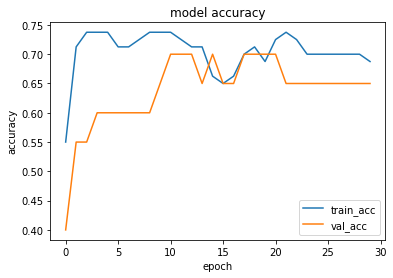

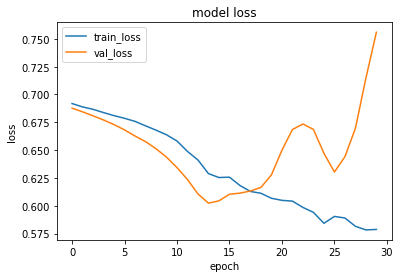

1it [00:00, 13443.28it/s]
file is another_control.mov, prediction is [[0.09745258]]
1it [00:00, 15420.24it/s]
file is short_armflapping.mov, prediction is [[0.27655834]]
1it [00:00, 13888.42it/s]
file is control_far.mov, prediction is [[0.09307885]]
1it [00:00, 12826.62it/s]
file is long_armflapping.mov, prediction is [[0.11881715]]
1it [00:00, 11366.68it/s]
file is me_reading_control.mov, prediction is [[0.10524976]]
1it [00:00, 16070.13it/s]
file is me_armflapping.mov, prediction is [[0.20522901]]
Epoch 1/30
3/3 [==============================] - 0s 150ms/step - loss: 0.6123 - accuracy: 0.6750 - val_loss: 0.5889 - val_accuracy: 0.7000
Epoch 2/30
3/3 [==============================] - 0s 148ms/step - loss: 0.5983 - accuracy: 0.6625 - val_loss: 0.5754 - val_accuracy: 0.7500
Epoch 3/30
3/3 [==============================] - 0s 146ms/step - loss: 0.5936 - accuracy: 0.6625 - val_loss: 0.5815 - val_accuracy: 0.6500
Epoch 4/30
3/3 [==============================] - 0s 149ms/step - loss: 0.5

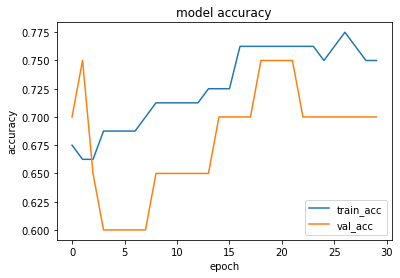

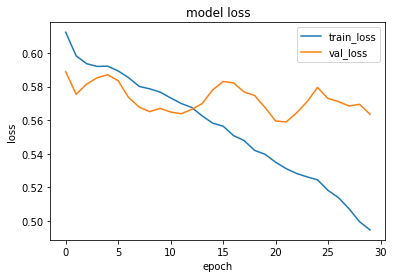

1it [00:00, 5991.86it/s]
file is another_control.mov, prediction is [[0.24263448]]
1it [00:00, 18477.11it/s]
file is short_armflapping.mov, prediction is [[0.757362]]
1it [00:00, 18558.87it/s]
file is control_far.mov, prediction is [[0.02984589]]
1it [00:00, 14463.12it/s]
file is long_armflapping.mov, prediction is [[0.647511]]
1it [00:00, 17848.10it/s]
file is me_reading_control.mov, prediction is [[0.43192852]]
1it [00:00, 18157.16it/s]
file is me_armflapping.mov, prediction is [[0.73824054]]
Epoch 1/30
3/3 [==============================] - 0s 131ms/step - loss: 0.5017 - accuracy: 0.7125 - val_loss: 0.5092 - val_accuracy: 0.7500
Epoch 2/30
3/3 [==============================] - 0s 127ms/step - loss: 0.4941 - accuracy: 0.7500 - val_loss: 0.5091 - val_accuracy: 0.7000
Epoch 3/30
3/3 [==============================] - 0s 124ms/step - loss: 0.4884 - accuracy: 0.7875 - val_loss: 0.5134 - val_accuracy: 0.7000
Epoch 4/30
3/3 [==============================] - 0s 121ms/step - loss: 0.4976 -

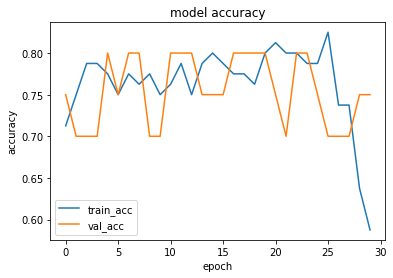

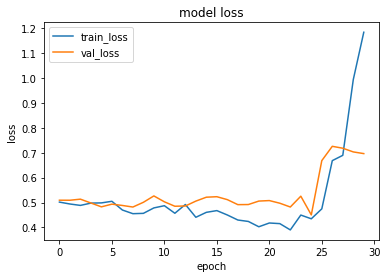

1it [00:00, 16131.94it/s]
file is another_control.mov, prediction is [[0.01148856]]
1it [00:00, 18236.10it/s]
file is short_armflapping.mov, prediction is [[0.8941593]]
1it [00:00, 16980.99it/s]
file is control_far.mov, prediction is [[0.01151681]]
1it [00:00, 17189.77it/s]
file is long_armflapping.mov, prediction is [[0.01142931]]
1it [00:00, 18236.10it/s]
file is me_reading_control.mov, prediction is [[0.01151991]]
1it [00:00, 14926.35it/s]
file is me_armflapping.mov, prediction is [[0.01117346]]
Epoch 1/30
3/3 [==============================] - 0s 140ms/step - loss: 1.0469 - accuracy: 0.6625 - val_loss: 1.3276 - val_accuracy: 0.5000
Epoch 2/30
3/3 [==============================] - 0s 120ms/step - loss: 1.1154 - accuracy: 0.6375 - val_loss: 1.1865 - val_accuracy: 0.5500
Epoch 3/30
3/3 [==============================] - 0s 128ms/step - loss: 1.0732 - accuracy: 0.6375 - val_loss: 1.1369 - val_accuracy: 0.5500
Epoch 4/30
3/3 [==============================] - 0s 138ms/step - loss: 1.02

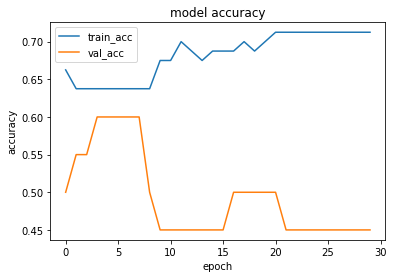

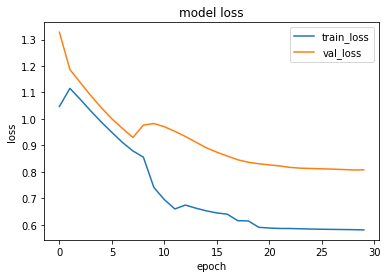

1it [00:00, 17189.77it/s]
file is another_control.mov, prediction is [[0.16077563]]
1it [00:00, 17924.38it/s]
file is short_armflapping.mov, prediction is [[0.68533146]]
1it [00:00, 18477.11it/s]
file is control_far.mov, prediction is [[0.1609033]]
1it [00:00, 17848.10it/s]
file is long_armflapping.mov, prediction is [[0.16051012]]
1it [00:00, 16710.37it/s]
file is me_reading_control.mov, prediction is [[0.16091809]]
1it [00:00, 17331.83it/s]
file is me_armflapping.mov, prediction is [[0.15890726]]
Epoch 1/30
3/3 [==============================] - 0s 141ms/step - loss: 0.6639 - accuracy: 0.6250 - val_loss: 0.4709 - val_accuracy: 0.8000
Epoch 2/30
3/3 [==============================] - 0s 126ms/step - loss: 0.6621 - accuracy: 0.6250 - val_loss: 0.4734 - val_accuracy: 0.8000
Epoch 3/30
3/3 [==============================] - 0s 123ms/step - loss: 0.6591 - accuracy: 0.6250 - val_loss: 0.4804 - val_accuracy: 0.8000
Epoch 4/30
3/3 [==============================] - 0s 126ms/step - loss: 0.65

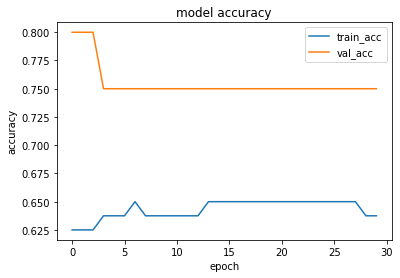

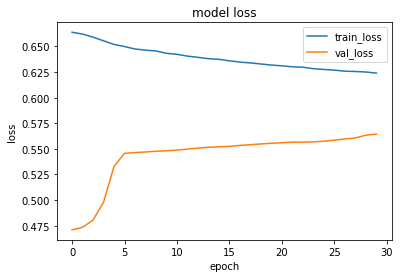

1it [00:00, 17848.10it/s]
file is another_control.mov, prediction is [[0.2662805]]
1it [00:00, 18157.16it/s]
file is short_armflapping.mov, prediction is [[0.6228346]]
1it [00:00, 15650.39it/s]
file is control_far.mov, prediction is [[0.26648802]]
1it [00:00, 14266.34it/s]
file is long_armflapping.mov, prediction is [[0.2658829]]
1it [00:00, 18477.11it/s]
file is me_reading_control.mov, prediction is [[0.2665158]]
1it [00:00, 13706.88it/s]file is me_armflapping.mov, prediction is [[0.26344714]]



In [36]:
from tqdm import tqdm 

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=False), 
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005), metrics = ['accuracy'])
cross_validate(model, epochs = 30, callbacks=[])

In [27]:
print

<function print>

In [18]:
modelo = deepcopy(model_7)

TypeError: cannot pickle '_thread.RLock' object